In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl

from pykalman import KalmanFilter
from datetime import datetime
from numpy import log, polyfit, sqrt, std, subtract
import statsmodels
import math
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#function to find cointegrated pairs
def find_cointegrated_pairs(data, critial_level = 0.01):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < critial_level:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [3]:
def KalmanFilterAverage(x):
    
  # Construct a Kalman filter
    from pykalman import KalmanFilter
    kf = KalmanFilter(transition_matrices = [1],
     observation_matrices = [1],
     initial_state_mean = 0,
     initial_state_covariance = 1,
     observation_covariance=1,
     transition_covariance=.01)
    
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means

  

# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
     initial_state_mean=[0,0],
     initial_state_covariance=np.ones((2, 2)),
     transition_matrices=np.eye(2),
     observation_matrices=obs_mat,
     observation_covariance=2,
     transition_covariance=trans_cov)

    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means

In [4]:
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))

    if halflife <= 0:
        halflife = 1
    return halflife

In [5]:
import datetime as dt
import pandas_datareader.data as web

ls_key = 'Adj Close'
start= dt.datetime(2007,12,1)
end= dt.datetime(2017,12,1)

stocks = ['SHW','CSX','CLX','GIS','BDX',\
          'JNJ','HPQ','WMB','JPM','BAC',\
          'AAPL','OXY','CAG','T','VZ',\
          'SPY','EBAY','MSFT','IBM','JNPR',\
          'NVDA','GS','PGR','BK','COST',\
          'CSCO','HD','LMT','NOC','GPS']

df=web.DataReader(stocks,'yahoo',start,end)
cleanData = df[ls_key]
cleanData.head()
#cleanData.dtypes

Symbols,AAPL,BAC,BDX,BK,CAG,CLX,COST,CSCO,CSX,EBAY,...,MSFT,NOC,NVDA,OXY,PGR,SHW,SPY,T,VZ,WMB
Date,,,,,,,,,,,,,,,,,,,,,
2007-12-03,17.110838,37.902767,66.226135,38.655056,12.427400,46.313011,51.217243,22.106651,9.672471,13.867846,...,25.226402,55.086971,29.586885,47.957619,13.862777,52.682468,117.646500,21.056437,23.094385,17.772715
2007-12-04,17.201725,37.269264,65.500885,38.646992,12.266334,46.234211,52.923454,21.617529,9.672471,13.859427,...,25.111465,55.114174,29.559143,47.148666,13.900571,50.738487,116.594925,20.825405,23.474918,17.630978
2007-12-05,17.746065,38.250256,66.902504,38.961910,12.276396,46.384632,53.290722,22.034479,9.911180,14.036196,...,26.168947,55.005444,31.093962,47.787663,14.104656,51.765663,118.546677,21.133434,23.860815,17.772715
2007-12-06,18.171778,38.867599,66.951408,39.979366,13.051538,46.492081,54.193550,22.283056,10.224782,14.212963,...,26.475471,56.153805,31.722673,49.494053,14.611095,53.327625,120.243462,21.353462,23.807220,17.954945
2007-12-07,18.587925,38.368645,67.375145,39.535240,13.046501,46.714100,54.958687,22.010422,10.245845,14.196128,...,26.460144,56.459564,31.325106,49.330303,14.626211,52.826778,120.219589,21.160942,24.278858,18.005569


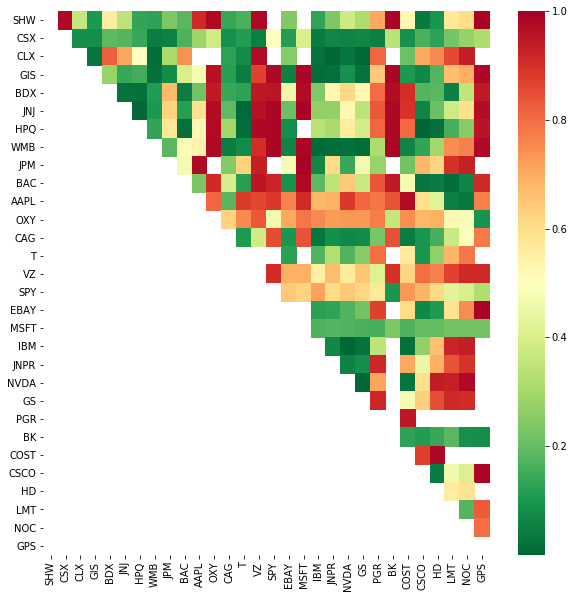

[('BDX', 'LMT'), ('BDX', 'NOC'), ('CLX', 'COST'), ('CLX', 'HD'), ('COST', 'SHW'), ('JPM', 'MSFT'), ('MSFT', 'NOC')]


In [6]:
#HeatMap shows level of cointegration
#print out cointegrated pairs, i.e. p-values <.05

scores, pvalues, pairs = find_cointegrated_pairs(cleanData)
import seaborn
m = [0,0.2,0.4,0.6,0.8,1]
plt.figure(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=stocks, 
                yticklabels=stocks, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.99)
                )
plt.show()
print(pairs)

# Trading with Kalman Filter

In [7]:
def BID_ASK(series):
    prices = pd.DataFrame(series)
    daily_return = prices.pct_change(1) 
    Scov = statsmodels.tsa.stattools.acovf(daily_return,missing='drop',fft=True)
    spread = np.zeros(len(Scov))
    for i in range(0,len(Scov)):
        if Scov[i]<0:
            spread[i] = 2*math.sqrt(-Scov[i])
        else:
            spread[i] = 0
    return spread

In [8]:
def trade_KFHL(x, y):
    #############################################################
    # INPUT:
    # x: the price series of stock one
    # y: the price series of stock two

    # run regression to find hedge ratio and then create spread series
    df1 = pd.DataFrame({'y':y,'x':x})
    state_means = KalmanFilterRegression(KalmanFilterAverage(x),KalmanFilterAverage(y))

    df1['hr'] = - state_means[:,0]
    df1['spread'] = df1.y + (df1.x * df1.hr)

    # calculate half life
    halflife = half_life(df1['spread'])

    # calculate z-score with window = half life period
    meanSpread = df1.spread.rolling(window=halflife).mean()
    stdSpread = df1.spread.rolling(window=halflife).std()
    df1['zScore'] = (df1.spread-meanSpread)/stdSpread

    
   ##############################################################
    # trading logic
    entryZscore = 1
    exitZscore = 0.5
    
    df1['BAx'] = np.zeros(len(x))
    df1['BAy'] = np.zeros(len(y))
    df1['BAx'].iloc[:len(x)-1]=BID_ASK(x)
    df1['BAy'].iloc[:len(y)-1]=BID_ASK(y)
    trans_cost = .0025


    #set up num units long
    df1['long entry'] = ((df1.zScore < - entryZscore) & ( df1.zScore.shift(1) > - entryZscore))
    df1['long exit'] = ((df1.zScore > - exitZscore) & (df1.zScore.shift(1) < - exitZscore)) 
    df1['num units long'] = np.nan 
    df1.loc[df1['long entry'],'num units long'] = 1 
    df1.loc[df1['long exit'],'num units long'] = 0 
    df1['num units long'][0] = 0 
    df1['num units long'] = df1['num units long'].fillna(method='pad') 
    
    #set up num units short 
    df1['short entry'] = ((df1.zScore > entryZscore) & ( df1.zScore.shift(1) < entryZscore))
    df1['short exit'] = ((df1.zScore < exitZscore) & (df1.zScore.shift(1) > exitZscore))
    df1.loc[df1['short entry'],'num units short'] = -1
    df1.loc[df1['short exit'],'num units short'] = 0
    df1['num units short'][0] = 0
    df1['num units short'] = df1['num units short'].fillna(method='pad')

    df1['numUnits'] = df1['num units long'] + df1['num units short']
    df1['spread pct ch'] = (df1['spread'] - df1['spread'].shift(1)) / (((df1['x']-df1['BAx']) * abs(df1['hr'])) + (df1['y']-df1['BAy']))
    df1['port rets'] = (1-trans_cost) * df1['spread pct ch'] * df1['numUnits'].shift(1)

    df1['cum rets'] = df1['port rets'].cumsum()

    ##############################################################

    try:
        sharpe = ((df1['port rets'].mean() / df1['port rets'].std()) * sqrt(252))
    except ZeroDivisionError:
        sharpe = 0.0

    ##############################################################
    start_val = 0
    end_val = df1['cum rets'].iat[-1]

    start_date = df1.iloc[0].name
    end_date = df1.iloc[-1].name
    days = (end_date - start_date).days


    return df1['cum rets'], sharpe

In [9]:
pnl_df = pd.DataFrame()

for i in range(0,len(pairs)):
    cumPnL,sharpe = trade_KFHL(cleanData[pairs[i][0]].iloc[:1763],cleanData[pairs[i][1]].iloc[:1763])
    pnl_df[i] = cumPnL
pnl_df['Total'] = pnl_df.sum(axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


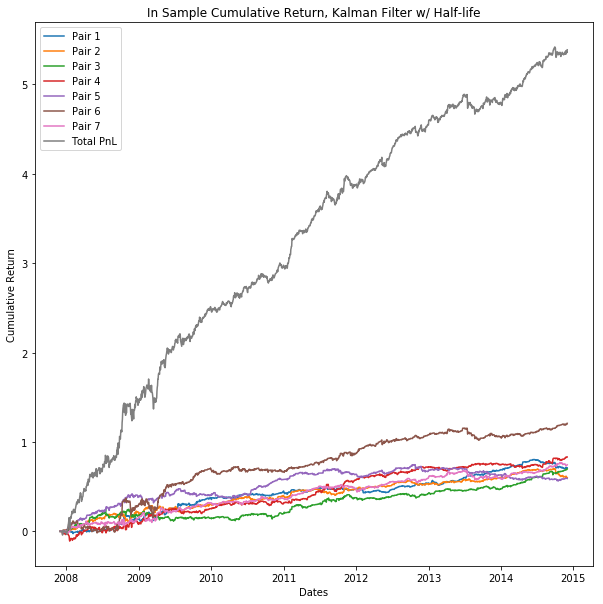

In [10]:
dates = pd.date_range(start='12/1/2007',end='12/1/2014',periods=1763)

plt.figure(figsize=(10,10))
plt.plot(dates,pnl_df)
plt.title("In Sample Cumulative Return, Kalman Filter w/ Half-life")
plt.legend(('Pair 1','Pair 2','Pair 3','Pair 4','Pair 5','Pair 6','Pair 7','Total PnL'))
plt.ylabel('Cumulative Return')
plt.xlabel('Dates')
plt.show()